## Gender Detection
---



### Packaging

In [2]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load the dataset

In [ ]:
!unzip "/content/gdrive/MyDrive/CV2/FaceData.zip" -d "/content/"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/FaceData/34_1_0_20170109004742195.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: /content/FaceData/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: /conten

In [ ]:
BASE_DIR ='/content/FaceData'
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  gender_label = int(img_components[1])

  # Append the image_path and gender_label
  gender_labels.append(gender_label)
  image_paths.append(image_path)


  0%|          | 0/9779 [00:00<?, ?it/s]

In [ ]:
print(f'Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of gender_labels: 9779, Number of image_paths: 9779


In [ ]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['gender'] = image_paths, gender_labels
df.head(5)

,image_path,gender
0,/content/FaceData/65_0_0_20170111201117758.jpg...,0
1,/content/FaceData/36_1_0_20170105164513676.jpg...,1
2,/content/FaceData/40_0_0_20170104201930209.jpg...,0
3,/content/FaceData/1_0_0_20170110213042997.jpg....,0
4,/content/FaceData/1_1_0_20170109190811756.jpg....,1


In [ ]:
gender_counts = df['gender'].value_counts()
print(gender_counts)


1    5407
0    4372
Name: gender, dtype: int64


## Exploratory Data Anlysis

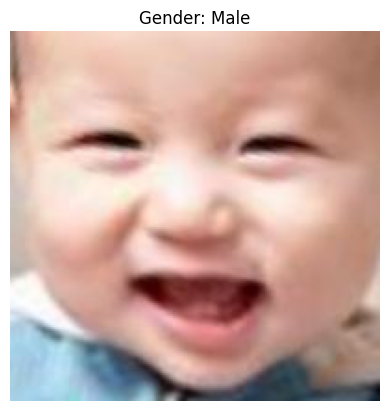

In [ ]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)


<Axes: ylabel='count'>

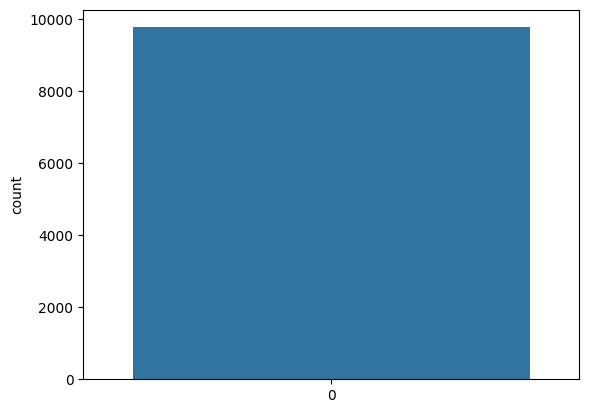

In [ ]:
sns.countplot(df['gender'])

The number of samples for females are slightly higher than that of males. However, the dataset is not highly imbalanced.

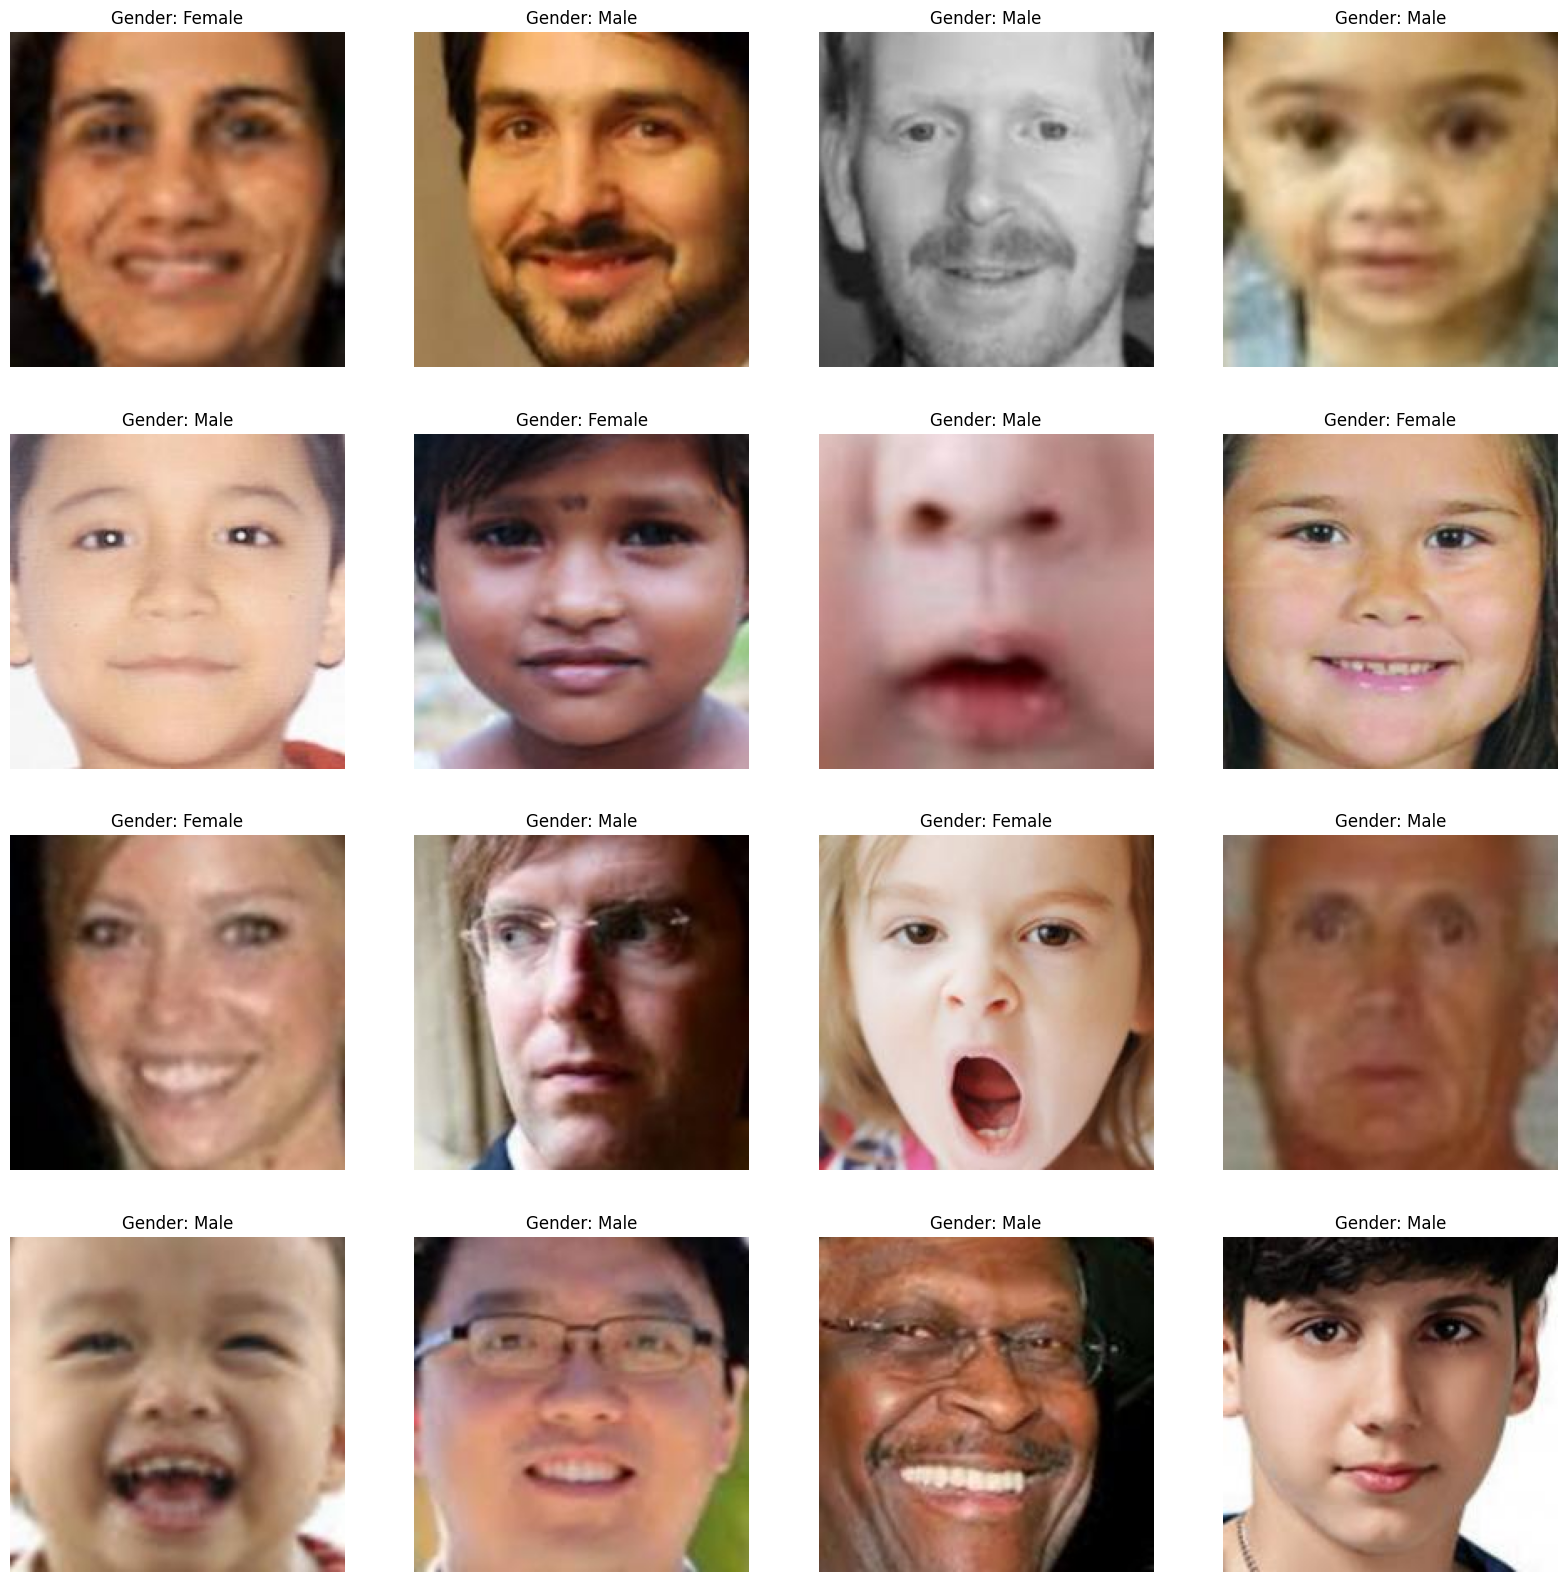

In [ ]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Gender: {gender_mapping[gender]}')
    plt.imshow(img)

## Feature Extraction

In [10]:
from keras.applications.vgg16 import VGG16
from sklearn import svm
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the VGG16 model but exclude the top layer, which is used for classification
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
def extract_features(img_paths):
    imgs = [image.load_img(img_path, target_size=(224, 224)) for img_path in img_paths]
    x = np.array([image.img_to_array(img) for img in imgs])
    x = preprocess_input(x)
    features = base_model.predict(x)
    return np.squeeze(features)

In [ ]:
# Extract features for all images
batch_size = 8  # Adjust based on your system's memory
features = []

for i in range(0, len(df['image_path']), batch_size):
    batch_paths = df['image_path'][i:i+batch_size]
    features.extend(extract_features(batch_paths))


In [ ]:
# X.shape

In [ ]:
# X = X / 255.0

In [ ]:
# Prepare the features and labels
X = np.array(features).reshape(len(features), -1)  # Flatten the features
y_gender = np.array(df['gender'])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_gender, test_size=0.2, random_state=42)

# Train the SVM classifier
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)


SVC(C=1, kernel='linear')

In [ ]:
# Test the model
accuracy = clf.score(X_test, y_test)
print('Model accuracy:', accuracy)

Model accuracy: 0.8358895705521472


In [ ]:
import joblib

# Save the model
joblib.dump(clf, 'svm_gender_plus.pkl')

# Copy the model to your Google Drive
!cp -r ./svm_gender_plus.pkl /content/gdrive/MyDrive/CV2/

## Predicting Test Data

In [16]:
import urllib.request
import cv2
import numpy as np
from joblib import load
import matplotlib.pyplot as plt

# URL of the Haar Cascade model
url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"

# Path to save the model
save_path = "haarcascade_frontalface_default.xml"

# Download and save the model
urllib.request.urlretrieve(url, save_path)

('haarcascade_frontalface_default.xml',
 <http.client.HTTPMessage at 0x7bbb3b7ffd90>)

In [17]:
# Load the pre-trained models
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
svm_gender = load('gdrive/MyDrive/CV2/svm_gender_plus.pkl')  # replace with the path to your SVM model

# Load the image
image = cv2.imread('7.jpg')

# Detect faces in the image
faces = face_detector.detectMultiScale(image, 1.1, 4)

In [ ]:
# Initialize counters
male_count = 0
female_count = 0

# Loop over the faces
for (x, y, w, h) in faces:
    # Extract the face
    face = cv2.resize(image[y:y+h, x:x+w], (224, 224))  # Resize to match the input size of VGG16

    # Convert the face to RGB and normalize it
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_rgb = np.expand_dims(face_rgb, axis=0)
    face_rgb = preprocess_input(face_rgb)  # Normalize to match the preprocessing of VGG16

    # Extract features using VGG16
    face_features = base_model.predict(face_rgb)
    face_features_flattened = np.array(face_features).reshape(1, -1)  # Flatten the features

    # Predict the gender of the face
    prediction = svm_gender.predict(face_features_flattened)

    # Update the counters
    if prediction[0] == 0:  # assuming that '0' is the label for male
        male_count += 1
        color = (153, 255, 51)  # Blue for male
    else:
        female_count += 1
        color = (255, 105, 180)  # Pink for female

    # Draw a rectangle around the detected face with the color based on the predicted gender
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

    # Display the resized face and the prediction
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted gender: {"Male" if prediction[0] == 0 else "Female"}')
    plt.show()

# Print the results
print(f'Number of males: {male_count}')
print(f'Number of females: {female_count}')

# Display the image with detected faces
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Faces')
plt.show()
